In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

df = pd.read_excel(r"C:\Users\brend\OneDrive - Stonehill College\All Cape League Trackman.xlsx")

In [2]:
df = df.dropna(subset=[
    "pfxx", "pfxz", "Extension", "PlateLocSide",
    "RelSpeed", "SpinRate", "TaggedPitchType", "PitcherTeam"
])
pitch_type_map = {
    'Fastball': 'Four-Seam',
    'FourSeamFastBall': 'Four-Seam',
    'FourSeamFour-Seam': 'Four-Seam',

    'Changeup': 'ChangeUp',
    
    'TwoSeamFastBall': 'Two-Seam',
    'TwoSeamFour-Seam': 'Two-Seam',

    'ChangeUp': 'ChangeUp',
    'Curveball': 'Curveball',
    'Slider': 'Slider',
    'Sweeper': 'Slider',
    'Cutter': 'Cutter',
    'Sinker': 'Sinker',
    'Splitter': 'Splitter',
    'Knuckleball': 'Knuckleball',

    'Other': 'Other',
    'Undefined': 'Undefined'
}

df['TaggedPitchType'] = df['TaggedPitchType'].replace(pitch_type_map)

valid_pitches = ["Four-Seam", "Slider", "Sinker", "Two-Seam", 
                 "Cutter", "Splitter", "Curveball", "ChangeUp"]

df = df[df["TaggedPitchType"].isin(valid_pitches)]

print(df["Pitcher"].unique())
print(df[df["Pitcher"] == "Dorn, Jake"]["TaggedPitchType"].value_counts())

df = df[df["PitcherTeam"] == "FAL_COM"]

features = [
    "pfxx", "pfxz", "Extension",
    "PlateLocSide", "RelSpeed", "SpinRate", "SpeedDrop"
]

df[features] = df[features].apply(pd.to_numeric, errors='coerce')

df = df.dropna(subset=features)

min_pitches = 15
pitch_counts = df.groupby(["Pitcher", "TaggedPitchType"]).size().unstack(fill_value=0)
qualified_pitchers = pitch_counts[(pitch_counts >= min_pitches).sum(axis=1) >= 2].index
df = df[df["Pitcher"].isin(qualified_pitchers)]

def compute_kde_deception(pitch_df, features, bandwidth=0.3):
    deception_scores = []
    for i, row in pitch_df.iterrows():
        current = row[features].to_numpy(dtype=float)
        pitch_type = row["TaggedPitchType"]
        pitcher = row["Pitcher"]
        ref_df = df[(df["Pitcher"] == pitcher) & (df["TaggedPitchType"] != pitch_type)]

        min_samples = len(features) * 5
        if len(ref_df) < min_samples:
            deception_scores.append(np.nan)
            continue

        kde = gaussian_kde(ref_df[features].values.T, bw_method=bandwidth)
        score = kde(current)
        deception_scores.append(score[0])
    return deception_scores

df["KDE_Deception_Score"] = compute_kde_deception(df, features)

pitcher_counts = df.groupby(["Pitcher", "TaggedPitchType"]).size().reset_index(name="Count")
pitcher_avg_scores = (
    df.groupby(["Pitcher", "TaggedPitchType"])["KDE_Deception_Score"]
    .mean()
    .reset_index()
    .merge(pitcher_counts, on=["Pitcher", "TaggedPitchType"])
)

pitcher_avg_scores = pitcher_avg_scores[pitcher_avg_scores["Count"] >= min_pitches]

pitcher_avg_scores = pitcher_avg_scores.sort_values("KDE_Deception_Score", ascending=True)

pitcher_avg_scores["KDE_Deception_Score"] = pitcher_avg_scores["KDE_Deception_Score"].replace(0, 1e-320)

pitcher_avg_scores["Log_Deception_Score"] = -np.log10(pitcher_avg_scores["KDE_Deception_Score"])
pitcher_avg_scores["Log_Deception_Score"] = pitcher_avg_scores["Log_Deception_Score"].round(2)

print(pitcher_avg_scores.head(10))

['Adelmann, Jonathan' 'Adetuyi, Kide' 'Aikens, Parker' 'Albanese, Tyler'
 'Alicea, Edwin' 'Applebey, Kaleb' 'Arther, Adam' 'August, Tyler'
 'Bailey, Carson' 'Baisley, Logan' 'Baker, Jackson' 'Ballard, Carson'
 'Barlow, Billy' 'Barr, Preston' 'Barrett, Easton' 'Bates, Zach'
 'Bauer, Douglas' 'Baumler, Trever' 'Bayer, Ty' 'Bayles, Max' 'Bean, Jake'
 'Beard, Trey' 'Bentley, Noah' 'Berg, Jack' 'Bevis, Logan' 'Bilka, Ryan'
 'Bixby, Mason' 'Black, Gavin' 'Blanco, Evan' 'Boaz, Folger'
 'Borberg, Ryan' 'Bowie, Rhys' 'Bradley-Cooney, Packey'
 'Bradley-Cooney, Packy' 'Breedlove, Austin' 'Brittain, Nate'
 'Brittain, Nathan' 'Brooks, Ryder' 'Brown, D.C.' 'Brown, DC'
 'Brown, Jack' 'Buckler, Ryan' 'Burns, Dane' 'Butler, Josh'
 'Butler, Tazwell' 'Calder, Ethan' 'Campbell, Kayden' 'Carey, Tate'
 'Carlon, Cole' 'Carpentier, Dean' 'Carson, Chase' 'Carson, Estridge'
 'Catalano, Michael' 'Chabot, Henry' 'Chase, Carson' 'Chmielewski, Tom'
 'Clayton, Canaan' 'Coats, TJ' 'Collera, Lazaro' 'Colucci, Joe'
 'C

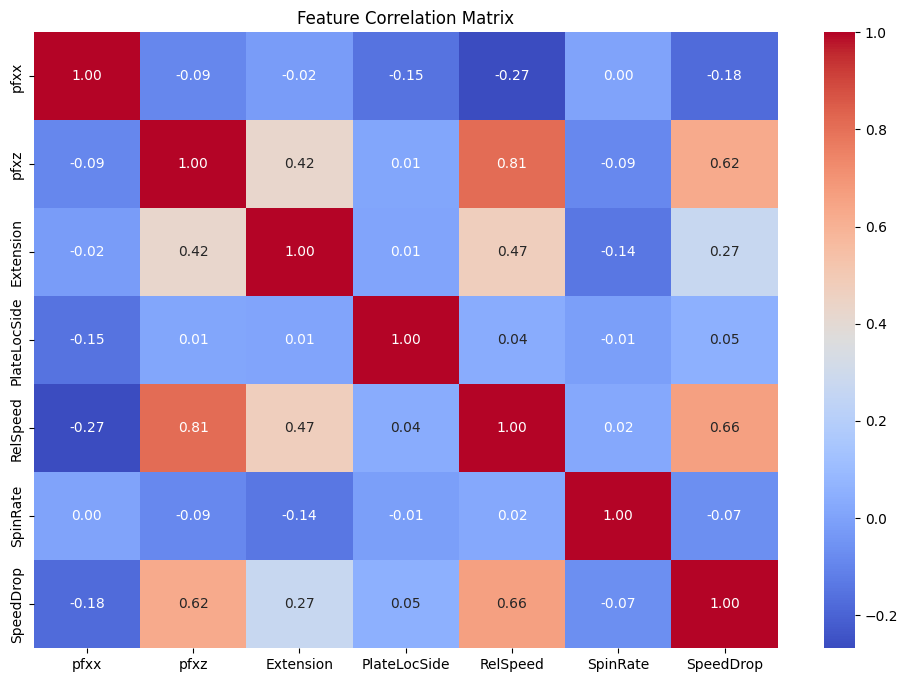

In [3]:
corr_matrix = df[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix")
plt.show()

C:\Users\brend\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


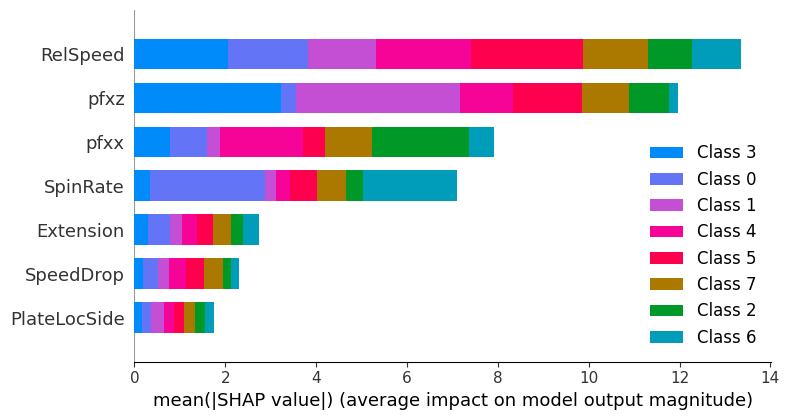

array(['Four-Seam', 'Slider', 'ChangeUp', 'Sinker', 'Curveball'],
      dtype=object)

In [4]:
X = df[features]
y = df["TaggedPitchType"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)
df[df["Pitcher"] == "Stiffler, Mac"]["TaggedPitchType"].unique()


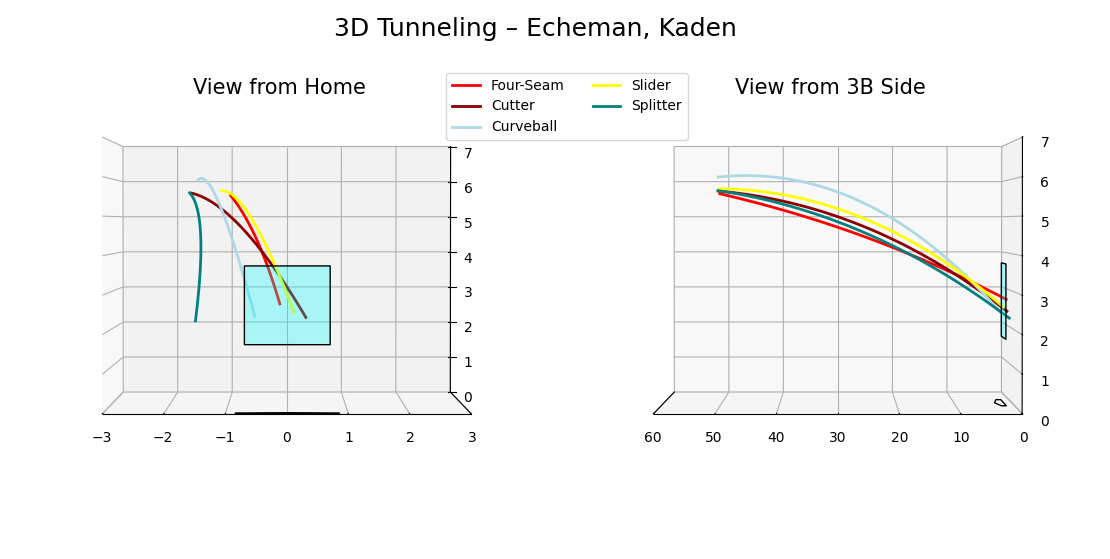

In [5]:
def get_avg_pitch(df, pitcher, pitch_type):
    subset = df[(df["Pitcher"] == pitcher) & (df["TaggedPitchType"] == pitch_type)]
    if subset.empty:
        return None
    metrics = ["x0", "y0", "z0", "vx0", "vy0", "vz0", "ax0", "ay0", "az0"]
    return subset[metrics].mean().to_dict()

def simulate_flight(pitch, dt=0.01):
    x = [pitch["x0"]]
    y = [pitch["y0"]]
    z = [pitch["z0"]]

    vx, vy, vz = pitch["vx0"], pitch["vy0"], pitch["vz0"]
    ax, ay, az = pitch["ax0"], pitch["ay0"], pitch["az0"]

    while y[-1] > 1.417:
        x_new = x[-1] + vx*dt + 0.5*ax*dt**2
        y_new = y[-1] + vy*dt + 0.5*ay*dt**2
        z_new = z[-1] + vz*dt + 0.5*az*dt**2

        vx += ax*dt
        vy += ay*dt
        vz += az*dt

        x.append(x_new)
        y.append(y_new)
        z.append(z_new)

    return np.array(x), np.array(y), np.array(z)

def add_strike_zone(ax):
    x_min, x_max = -0.7, 0.7
    z_min, z_max = 1.75, 3.75
    y_plate = 1.417
    verts = [[(x_min, y_plate, z_min), (x_max, y_plate, z_min),
              (x_max, y_plate, z_max), (x_min, y_plate, z_max)]]
    poly = Poly3DCollection(verts, facecolors='cyan', edgecolors='k', alpha=0.3)
    ax.add_collection3d(poly)

def add_home_plate(ax, y_plate=1.417):
    verts = [[(-0.85, y_plate, 0), (0.85, y_plate, 0), (0.85, y_plate+0.85, 0),
              (0, y_plate+1.56, 0), (-0.85, y_plate+0.85, 0)]]
    poly = Poly3DCollection(verts, facecolors='white', edgecolors='k')
    ax.add_collection3d(poly)

def plot_tunneling_3d_multi_animated(df, pitcher, pitch_types, color_scheme):
    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    flights = {}
    for pitch_type in pitch_types:
        pitch = get_avg_pitch(df, pitcher, pitch_type)
        if pitch is None:
            continue
        x, y, z = simulate_flight(pitch)
        flights[pitch_type] = (x, y, z)

    for ax in [ax1, ax2]:
        add_strike_zone(ax)
        add_home_plate(ax)
        ax.set_xlim(-3, 3)
        ax.set_ylim(0, 60)
        ax.set_zlim(0, 7)

    ax1.set_yticks([])
    ax1.view_init(elev=1, azim=270)
    ax1.set_title("View from Home", y=0.9, fontsize=15)

    ax2.view_init(elev=1, azim=180)
    ax2.set_xticks([])
    ax2.set_title("View from 3B Side", y=0.9, fontsize=15)

    fig.suptitle(f"3D Tunneling – {pitcher}", y=0.87, fontsize=18)

    line_objs = {}
    for pitch_type, (x, y, z) in flights.items():
        color = color_scheme.get(pitch_type, "black")
        l1, = ax1.plot([], [], [], color=color, linewidth=2, label=pitch_type)
        l2, = ax2.plot([], [], [], color=color, linewidth=2)
        line_objs[pitch_type] = (l1, l2, x, y, z)

    def update(frame):
        for pitch_type, (l1, l2, x, y, z) in line_objs.items():
            l1.set_data(x[:frame], y[:frame])
            l1.set_3d_properties(z[:frame])

            l2.set_data(x[:frame], y[:frame])
            l2.set_3d_properties(z[:frame])

        return [obj for sub in line_objs.values() for obj in sub[:2]]

    max_frames = max(len(v[0]) for v in flights.values())
    anim = FuncAnimation(fig, update, frames=max_frames, interval=20, blit=True)

    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.52, 0.80), ncol=2)

    fig.subplots_adjust(wspace=-.2)

    return anim

custom_colors = {
    "Four-Seam": "#FF0000",
    "Two-Seam": "#FF6666",
    "Sinker": "#FFA500",
    "ChangeUp": "#00CC66",
    "Slider": "#FFFF00",
    "Curveball": "#ADD8E6",
    "Cutter": "#8B0000",
    "Splitter": "#008080"
}

anim = plot_tunneling_3d_multi_animated(
    df,
    pitcher="Echeman, Kaden",
    pitch_types=("Four-Seam", "Cutter", "Curveball", "Slider", "Splitter"),
    color_scheme=custom_colors
)

HTML(anim.to_jshtml())